## Importing Necessary packages

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import datetime as dt
import numpy as np

from scipy.stats import iqr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, OPTICS, DBSCAN
from sklearn.neighbors import NearestNeighbors
from plotly.offline import iplot


## Loading the data

In [2]:
data_path = os.path.join(os.getcwd(), 'data\sales_data_sample.csv')
sales_data = pd.read_csv(data_path, encoding='iso-8859-1')
sales_data['ORDERDATE'] = pd.to_datetime(sales_data['ORDERDATE'])
sales_data.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [3]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ORDERNUMBER       2823 non-null   int64         
 1   QUANTITYORDERED   2823 non-null   int64         
 2   PRICEEACH         2823 non-null   float64       
 3   ORDERLINENUMBER   2823 non-null   int64         
 4   SALES             2823 non-null   float64       
 5   ORDERDATE         2823 non-null   datetime64[ns]
 6   STATUS            2823 non-null   object        
 7   QTR_ID            2823 non-null   int64         
 8   MONTH_ID          2823 non-null   int64         
 9   YEAR_ID           2823 non-null   int64         
 10  PRODUCTLINE       2823 non-null   object        
 11  MSRP              2823 non-null   int64         
 12  PRODUCTCODE       2823 non-null   object        
 13  CUSTOMERNAME      2823 non-null   object        
 14  PHONE             2823 n

As can be seen in the above output the columns: ADDRESSLINE2, STATE, POSTALCODE and TERRITORY have null data, but these columns are not defining for the segmentation of the clusters

# Cleanning


Let's verify if there are duplicated data to remove from the dataset as can be seen in the following output there isn't any data duplicated.

In [4]:
sales_data.duplicated().sum()

0

As can be seen in the following output, there are 6 possibles states for an order, for the analysis the sales will be filtered to keep only the shipped orders, because  

In [50]:
sales_data["STATUS"].unique()

array(['Shipped', 'Disputed', 'In Process', 'Cancelled', 'On Hold',
       'Resolved'], dtype=object)

# Exploratory Data Analysis (EDA)

# Univariate analysis

Text(0.5, 1.0, 'Distribution of the price of each solded product')

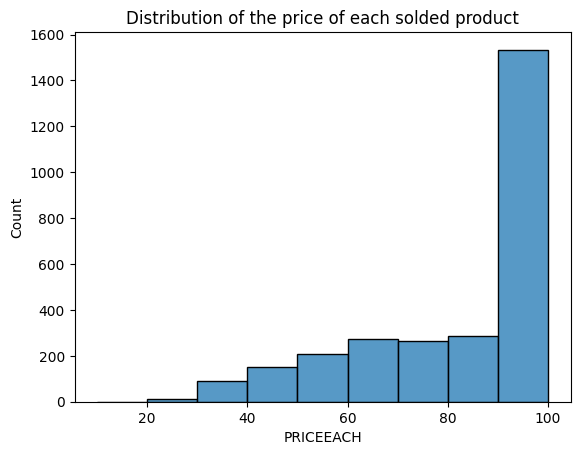

In [5]:
sns.histplot(data=sales_data, x="PRICEEACH", bins=list(range(10,110,10)))
plt.title("Distribution of the price of each solded product")

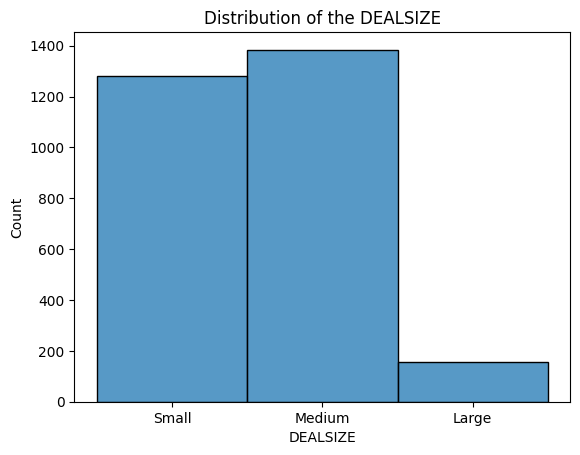

In [6]:
sns.histplot(data=sales_data, x="DEALSIZE")
plt.title("Distribution of the DEALSIZE")
plt.show()

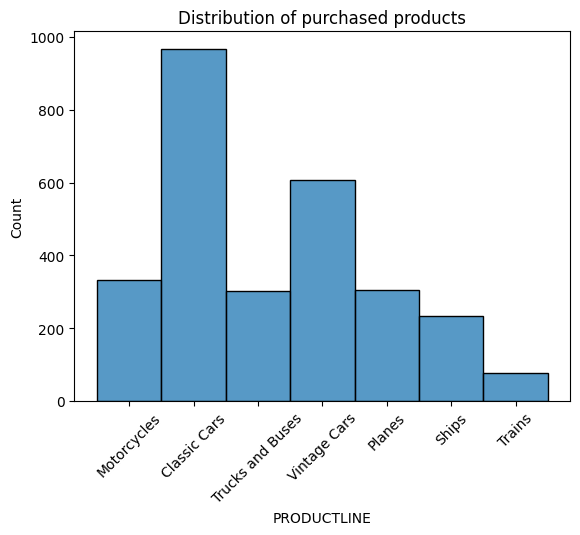

In [7]:
sns.histplot(data=sales_data, x="PRODUCTLINE")
plt.title("Distribution of purchased products")
plt.xticks(rotation=45, fontsize=10)
plt.show()

In [48]:
# Create basic choropleth map
# Aggregate the data by country
grouped_data = sales_data[["ORDERNUMBER", "COUNTRY"]].groupby('COUNTRY').count().reset_index()
grouped_data.rename(columns={"ORDERNUMBER": "ORDERSCOUNTS"}, inplace=True)
grouped_data
# Create the choropleth map
fig = px.choropleth(grouped_data, locations='COUNTRY', color='ORDERSCOUNTS',
                    locationmode="country names",
                    hover_name='COUNTRY', projection='natural earth',
                    title='Total Order Counts by Country')
fig.show()


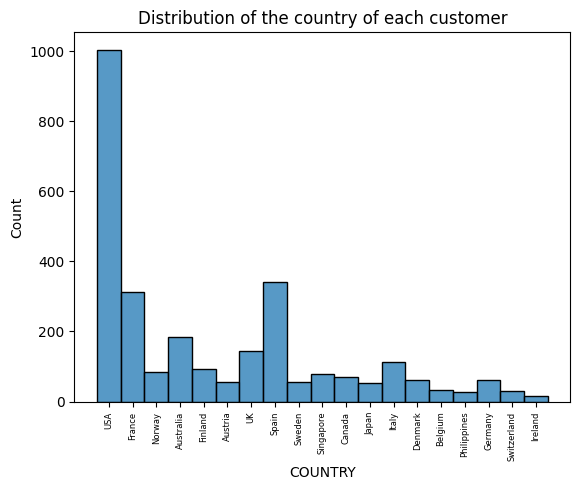

In [49]:
sns.histplot(data=sales_data, x="COUNTRY")
plt.title("Distribution of the country of each customer")
plt.xticks(rotation=90, fontsize=6)
plt.show()

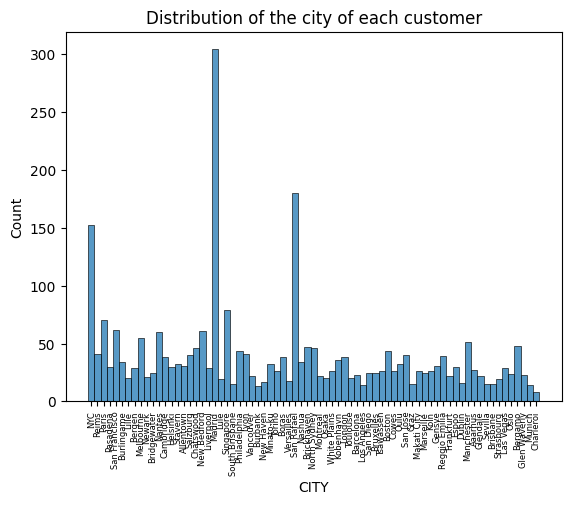

In [10]:
sns.histplot(data=sales_data, x="CITY")
plt.title("Distribution of the city of each customer")
plt.xticks(rotation=90, fontsize=6)
plt.show()

# Creating the Customer DataFrame 
The following code uses the `groupby()` method from the `pandas` library to group the `data` DataFrame by `CUSTOMERNAME`, and then applies an aggregation function to each group to create a new DataFrame called `customer_df`, this df contains information of interest of each customer

The aggregation function uses a dictionary to specify the columns to include in `customer_df` and the corresponding function to apply to each column. In this case, the function used for each column is a lambda function that extracts the first value of the column (using the `to_list()` method) or the unique values of the `PRODUCTLINE` column (using the `unique()` method).

Here's the resulting DataFrame:

```python
customer_df

In [11]:
customer_df = sales_data.groupby(by='CUSTOMERNAME').agg({"COUNTRY": lambda var: var.to_list()[0],
                                                   "CITY": lambda var: var.to_list()[0],
                                                   "PHONE": lambda var: var.to_list()[0],
                                                   "CONTACTLASTNAME": lambda var: var.to_list()[0],
                                                   "CONTACTFIRSTNAME": lambda var: var.to_list()[0],
                                                #    "PRODUCTLINE": lambda var: var.unique()
                                                  })

customer_df

,COUNTRY,CITY,PHONE,CONTACTLASTNAME,CONTACTFIRSTNAME
CUSTOMERNAME,,,,,
"AV Stores, Co.",UK,Manchester,(171) 555-1555,Ashworth,Victoria
Alpha Cognac,France,Toulouse,61.77.6555,Roulet,Annette
Amica Models & Co.,Italy,Torino,011-4988555,Accorti,Paolo
"Anna's Decorations, Ltd",Australia,North Sydney,02 9936 8555,O'Hara,Anna
Atelier graphique,France,Nantes,40.32.2555,Schmitt,Carine
...,...,...,...,...,...
"Vida Sport, Ltd",Switzerland,Gensve,0897-034555,Holz,Michael
Vitachrome Inc.,USA,NYC,2125551500,Frick,Michael
"Volvo Model Replicas, Co",Sweden,Lule,0921-12 3555,Berglund,Christina


# Creating the Product Line DataFrame

The Product Line DataFrame provides information on how many vehicles of each type each customer has purchased

The following code creates a new DataFrame called `product_line_df` using the `pd.DataFrame()` constructor from the `pandas` library. The DataFrame has the same index as `customer_df` (i.e., the unique customer names) and the columns are the unique values of the `PRODUCTLINE` column in the `data` DataFrame. This df provides information on how many vehicles of each type each customer has purchased

The code then groups the `data` DataFrame by `CUSTOMERNAME` using the `groupby()` method and iterates over each group. For each group, another for loop iterates over the columns of `product_line_df` and calculates the sum of the `QUANTITYORDERED` values for the corresponding product and customer. The result is stored in the corresponding cell of `product_line_df`.

Finally, the resulting DataFrame provides information on how many vehicles of each type each customer has purchased

In [12]:
product_line_df = pd.DataFrame(index=customer_df.index, columns=sales_data["PRODUCTLINE"].unique())

customer_group = sales_data.groupby(by='CUSTOMERNAME')

for customer_name, columns in customer_group:
    for product in product_line_df.columns.values:
        product_line_df.loc[customer_name, product] = columns[columns["PRODUCTLINE"] == product]["QUANTITYORDERED"].sum()
        
product_line_df


,Motorcycles,Classic Cars,Trucks and Buses,Vintage Cars,Planes,Ships,Trains
CUSTOMERNAME,,,,,,,
"AV Stores, Co.",0,628,0,773,0,257,120
Alpha Cognac,0,126,0,96,218,247,0
Amica Models & Co.,0,149,24,566,0,82,22
"Anna's Decorations, Ltd",219,744,286,220,0,0,0
Atelier graphique,71,156,0,43,0,0,0
...,...,...,...,...,...,...,...
"Vida Sport, Ltd",0,1078,0,0,0,0,0
Vitachrome Inc.,239,239,158,151,0,0,0
"Volvo Model Replicas, Co",0,230,171,134,0,80,32


# RFM Analysis

As the data is very old, the RFM analysis will work under the assumption that the current date is the date on which the last sale was made, so the actual year is 2005 and the last year for the frequency and monetary characteristics is 2004.
The following code is computing the recency, frequency, and monetary value for each customer using the following steps:

1. The `last_order_date` variable is set to the maximum value of the `ORDERDATE` column in the `data` DataFrame, which represents the date of the last order in the dataset.

2. The `current_date` variable is set to the same value as `last_order_date`, which assumes that the current date is the date on which the last sale was made.

3. The `last_year` variable is calculated as one year ago from the `current_date`, which is used to filter the data for the last year of sales in the dataset.

4. Three new columns are created in the `data` DataFrame: `RECENCY_days`, `FREQUENCY_last_year`, and `MONETARY_last_year`. These columns will be used to store the recency, frequency, and monetary value for each customer, respectively.

5. The `recency_quantity` variable is created by grouping the `data` DataFrame by `CUSTOMERNAME` and applying a lambda function to the `ORDERDATE` column that calculates the number of days between the `current_date` and the maximum order date for each customer(this says how long it has been since the customer placed their last order). This results in a DataFrame that contains the recency value for each customer.

6. The `frecuency_monetary_ordered_last_year` variable is created by filtering the `data` DataFrame to include only the rows where the `ORDERDATE` is greater than or equal to `last_year`, grouping the resulting DataFrame by `CUSTOMERNAME`, and applying a lambda function to three columns: `FREQUENCY_last_year`, `MONETARY_last_year`, and `QUANTITYORDERED`. The `FREQUENCY_last_year` column is used to calculate the frequency of orders (i.e., the number of unique order numbers), the `MONETARY_last_year` column is used to calculate the monetary value of orders (i.e., the sum of sales), and the `QUANTITYORDERED` column is used to calculate the total quantity ordered in the last year.

7. The `recency_quantity` and `frecuency_monetary_ordered_last_year` DataFrames are concatenated along the column axis using `pd.concat()` to create a new DataFrame called `rfm_data`. This DataFrame contains the recency, frequency, monetary value, and quantity ordered data for each customer.

8. Any missing values in `rfm_data` are filled with 0 using the `fillna()` method. The missing values ​​are the product of the fact that some clients have not placed orders in the last year.

The result of this cell is a DataFrame containning the RFM analysis of the data plus the `QUANTITYORDERED` characteristic that gives the meassurement of the total quantity ordered in the last year by each customer

In [13]:
# Getting the last order date from the 'data' DataFrame
last_order_date: dt.datetime = max(sales_data["ORDERDATE"])

# Assuming that the current date is the date on which the last sale was made
current_date: dt.datetime = last_order_date

# Calculating the date that was one year ago from the current date, this date will be used to filter the data from the current date to the last year to analyze the RFM
last_year = current_date - dt.timedelta(days=365)

# Creating new columns in the 'data' DataFrame for the RFM analysis
sales_data["RECENCY_days"] = sales_data["ORDERDATE"].copy() 
sales_data["FREQUENCY_last_year"] = sales_data["ORDERNUMBER"].copy()
sales_data["MONETARY_last_year"] = sales_data["SALES"].copy()

# Calculating the recency for each customer
recency_quantity = sales_data.groupby(by='CUSTOMERNAME').agg({"RECENCY_days": lambda order_dates: (current_date - order_dates.max()).days})

# Calculating the frequency, monetary value, and quantity ordered in the last year for each customer
frecuency_monetary_ordered_last_year = sales_data[sales_data["ORDERDATE"] >= last_year].groupby('CUSTOMERNAME').agg({"FREQUENCY_last_year": lambda order_number: len(order_number.unique()),
                                                                                                         "MONETARY_last_year": lambda sales: sales.sum(),
                                                                                                         "QUANTITYORDERED": lambda quantity: int(quantity.sum())})

# Renaming the 'QUANTITYORDERED' column to 'QUANTITYORDERED_last_year'
frecuency_monetary_ordered_last_year.rename(columns={"QUANTITYORDERED": "QUANTITYORDERED_last_year"}, inplace=True)

# Concatenating the recency, frequency, monetary, and quantity data into a single DataFrame for the RFM analysis
rfm_df = pd.concat([recency_quantity, frecuency_monetary_ordered_last_year], axis=1)

# Filling any missing values with 0
rfm_df.fillna(0, inplace=True)
rfm_df

,RECENCY_days,FREQUENCY_last_year,MONETARY_last_year,QUANTITYORDERED_last_year
CUSTOMERNAME,,,,
"AV Stores, Co.",195,2.0,106789.89,1208.0
Alpha Cognac,64,1.0,15139.12,172.0
Amica Models & Co.,264,2.0,94117.26,843.0
"Anna's Decorations, Ltd",83,2.0,65012.42,595.0
Atelier graphique,187,2.0,7619.66,114.0
...,...,...,...,...
"Vida Sport, Ltd",274,1.0,67281.01,595.0
Vitachrome Inc.,207,1.0,56372.87,468.0
"Volvo Model Replicas, Co",193,3.0,66005.88,595.0


# Adding the RFM Analysis to the Customer DataFrame

In [14]:
customer_df = pd.concat([rfm_df, customer_df], axis=1)
customer_df

,RECENCY_days,FREQUENCY_last_year,MONETARY_last_year,QUANTITYORDERED_last_year,COUNTRY,CITY,PHONE,CONTACTLASTNAME,CONTACTFIRSTNAME
CUSTOMERNAME,,,,,,,,,
"AV Stores, Co.",195,2.0,106789.89,1208.0,UK,Manchester,(171) 555-1555,Ashworth,Victoria
Alpha Cognac,64,1.0,15139.12,172.0,France,Toulouse,61.77.6555,Roulet,Annette
Amica Models & Co.,264,2.0,94117.26,843.0,Italy,Torino,011-4988555,Accorti,Paolo
"Anna's Decorations, Ltd",83,2.0,65012.42,595.0,Australia,North Sydney,02 9936 8555,O'Hara,Anna
Atelier graphique,187,2.0,7619.66,114.0,France,Nantes,40.32.2555,Schmitt,Carine
...,...,...,...,...,...,...,...,...,...
"Vida Sport, Ltd",274,1.0,67281.01,595.0,Switzerland,Gensve,0897-034555,Holz,Michael
Vitachrome Inc.,207,1.0,56372.87,468.0,USA,NYC,2125551500,Frick,Michael
"Volvo Model Replicas, Co",193,3.0,66005.88,595.0,Sweden,Lule,0921-12 3555,Berglund,Christina


# Bivariate Analysis

Bivariate analysis entails determining the correlation between two features.
Let's check the relationship between the Recency and the Frequency

In [15]:
fig = px.scatter(
    data_frame=customer_df,
    x = "RECENCY_days",
    y= "FREQUENCY_last_year",
    title = "Relationship between RECENCY VS FREQUENCY",
    # color = "COUNTRY",
    height=500
)
fig.show()

In the above picture we can see that customers that have less Frequency (amount of orders in the last year) have a higher value of Recency (time since the last purchased)

Let's check the relationship between the Recency and Monetary

In [16]:
fig = px.scatter(
    data_frame=customer_df,
    x = "RECENCY_days",
    y= "MONETARY_last_year",
    title = "Relationship between RECENCY VS MONETARY",
    color = "COUNTRY",
    height=500
)
fig.show()

In [17]:
fig = px.scatter(
    data_frame=customer_df,
    x = "QUANTITYORDERED_last_year",
    y= "MONETARY_last_year",
    title = "Relationship between QUANTITYORDERED VS MONETARY",
    # color = "COUNTRY",
    height=500
)
fig.show()

As can be seen in the above picture the features `QUANTITYORDERED_last_year` and `MONETARY_last_year` have a linear relationship so then one of both can be removed from the cluster analysis in order to reduce the dimmnencionality and simplify the analysis of the clusters. In this case `QUANTITYORDERED_last_year` feature will be removed.


In [18]:
fig = px.scatter(
    data_frame=customer_df,
    x = "FREQUENCY_last_year",
    y= "MONETARY_last_year",
    title = "Relationship between QUANTITYORDERED VS MONETARY",
    color = "COUNTRY",
    height=500
)
fig.show()

 # The Segmentation Model

In [19]:
std_scaler = StandardScaler()
rfm_array_scaled = std_scaler.fit_transform(rfm_df.iloc[:,0:3]) 
rfm_df_scaled = pd.DataFrame(rfm_array_scaled, columns=rfm_df.columns[0:3])


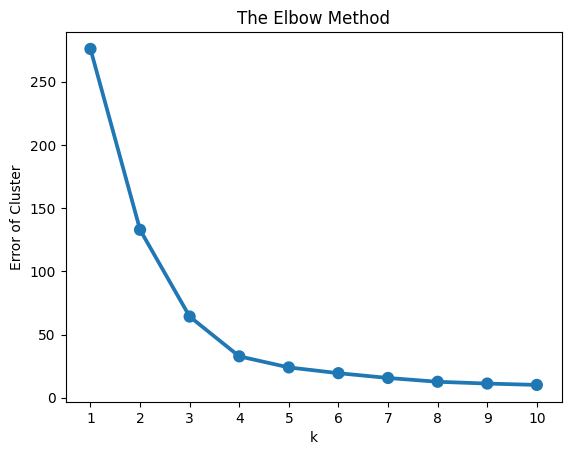

In [20]:
errors = []
for k in range(1, 11):
    kmeans_clustering = KMeans(n_clusters=k, random_state=42)
    kmeans_clustering.fit(rfm_array_scaled)
    errors.append(kmeans_clustering.inertia_)
    
 
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('Error of Cluster')
sns.pointplot(x=np.arange(start=1, stop=11), y=errors)
plt.show()

In [21]:
kmeans_clustering = KMeans(n_clusters=5, random_state=42)
kmeans_clustering.fit(rfm_array_scaled)

customer_df = customer_df.assign(KMeansLabel=kmeans_clustering.labels_)
customer_df

,RECENCY_days,FREQUENCY_last_year,MONETARY_last_year,QUANTITYORDERED_last_year,COUNTRY,CITY,PHONE,CONTACTLASTNAME,CONTACTFIRSTNAME,KMeansLabel
CUSTOMERNAME,,,,,,,,,,
"AV Stores, Co.",195,2.0,106789.89,1208.0,UK,Manchester,(171) 555-1555,Ashworth,Victoria,2
Alpha Cognac,64,1.0,15139.12,172.0,France,Toulouse,61.77.6555,Roulet,Annette,0
Amica Models & Co.,264,2.0,94117.26,843.0,Italy,Torino,011-4988555,Accorti,Paolo,2
"Anna's Decorations, Ltd",83,2.0,65012.42,595.0,Australia,North Sydney,02 9936 8555,O'Hara,Anna,0
Atelier graphique,187,2.0,7619.66,114.0,France,Nantes,40.32.2555,Schmitt,Carine,2
...,...,...,...,...,...,...,...,...,...,...
"Vida Sport, Ltd",274,1.0,67281.01,595.0,Switzerland,Gensve,0897-034555,Holz,Michael,2
Vitachrome Inc.,207,1.0,56372.87,468.0,USA,NYC,2125551500,Frick,Michael,2
"Volvo Model Replicas, Co",193,3.0,66005.88,595.0,Sweden,Lule,0921-12 3555,Berglund,Christina,2


In [22]:
rfm_df_scaled = rfm_df_scaled.assign(KMeansLabel=kmeans_clustering.labels_)
rfm_df = rfm_df.assign(KMeansLabel=kmeans_clustering.labels_)

fig = px.scatter_3d(
    data_frame=rfm_df,
    x= "RECENCY_days",
    y = "FREQUENCY_last_year",
    z= "MONETARY_last_year",
    title = "Relationship between RECENCY VS FREQUENCY VS MONETARY based on the customer cluster",
    color = "KMeansLabel",
    height=500
)
fig.update_traces(marker_size = 4)
fig.show()
customer_clusters_summarize = customer_df.groupby("KMeansLabel")[["RECENCY_days", "FREQUENCY_last_year", "MONETARY_last_year"]].median()
customer_clusters_summarize.assign(CustomersCount=np.bincount(kmeans_clustering.labels_))

,RECENCY_days,FREQUENCY_last_year,MONETARY_last_year,CustomersCount
KMeansLabel,,,,
0,111.0,2.0,30091.640,21
1,1.0,13.5,494031.570,2
2,207.5,1.0,45102.695,40
3,457.5,0.0,0.000,12
4,30.0,3.0,91279.140,17


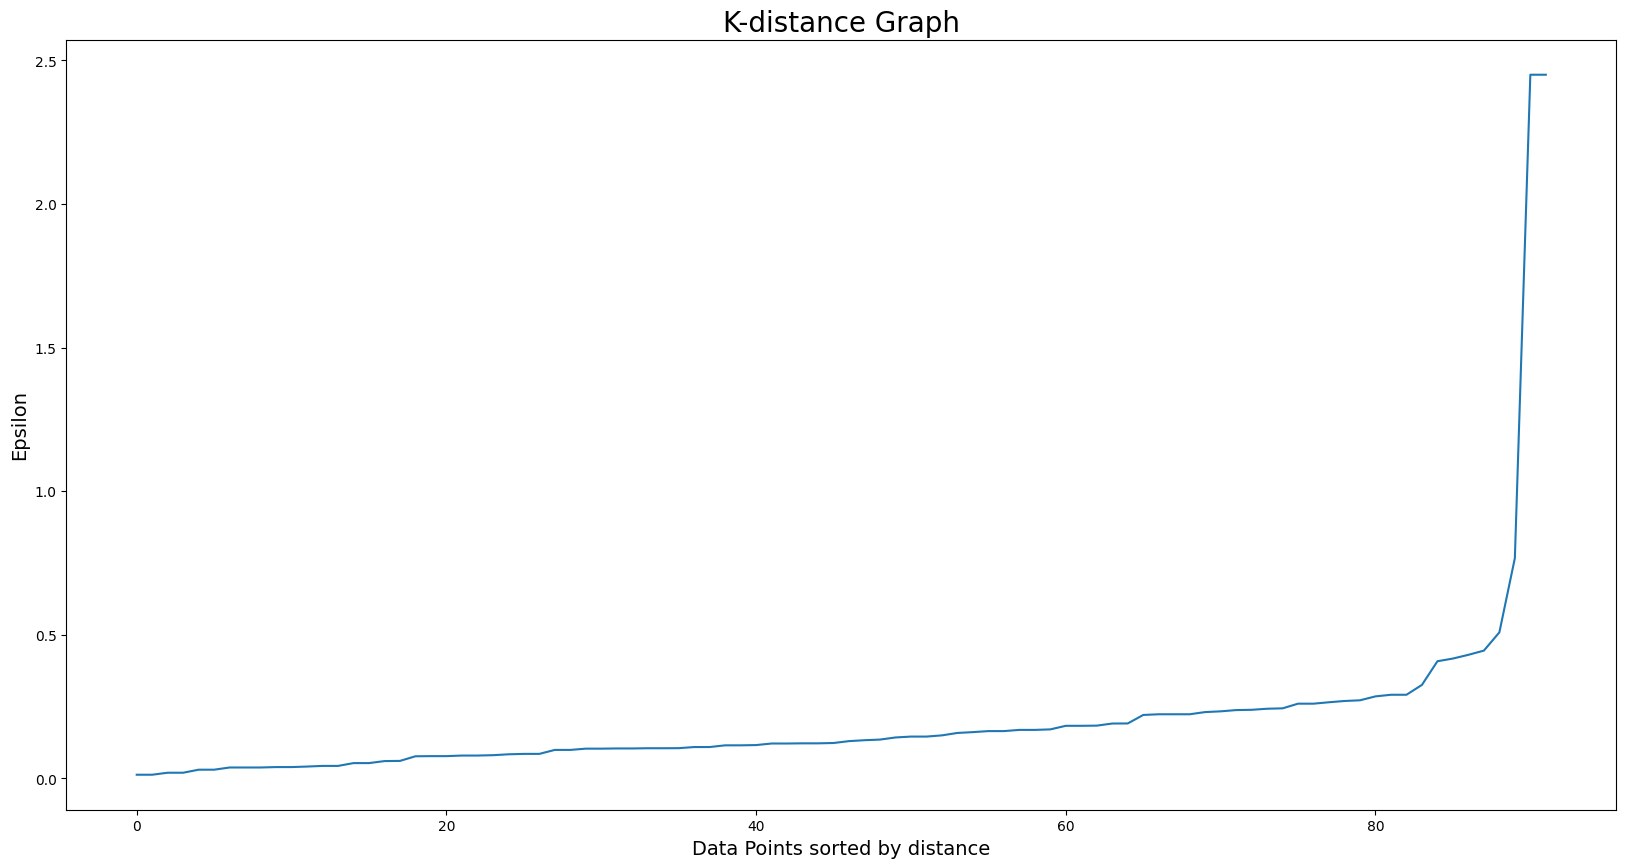

In [23]:
neigh = NearestNeighbors(n_neighbors=2).fit(rfm_df_scaled)
distances, indices = neigh.kneighbors(rfm_df_scaled)

# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [24]:
min_points = rfm_array_scaled.shape[1] + 1
dbscan_clustering = DBSCAN(min_samples=min_points, eps=0.5).fit(rfm_array_scaled)
customer_df = customer_df.assign(DBSCANLabel=dbscan_clustering.labels_)
rfm_df_scaled = rfm_df_scaled.assign(DBSCANLabel=dbscan_clustering.labels_)
rfm_df = rfm_df.assign(DBSCANLabel=dbscan_clustering.labels_)

fig = px.scatter_3d(
    data_frame=rfm_df,
    x= "RECENCY_days",
    y = "FREQUENCY_last_year",
    z= "MONETARY_last_year",
    title = "Relationship between RECENCY VS FREQUENCY VS MONETARY based on customer cluster",
    color = "DBSCANLabel",
    height=500
)
fig.update_traces(marker_size = 4)
fig.show()

customer_clusters_summarize = customer_df.groupby("DBSCANLabel")[["RECENCY_days", "FREQUENCY_last_year", "MONETARY_last_year"]].median()
customer_clusters_summarize.assign(CustomersCount=np.unique(dbscan_clustering.labels_, return_counts=True)[1])
# np.unique(dbscan_clustering.labels_, return_counts=True)[1]


,RECENCY_days,FREQUENCY_last_year,MONETARY_last_year,CustomersCount
DBSCANLabel,,,,
-1,1.5,4.0,151131.520,6
0,136.0,2.0,58621.885,30
1,207.0,1.0,34145.470,37
2,457.5,0.0,0.000,12
3,38.0,3.0,100924.660,7


In [25]:
min_points = rfm_array_scaled.shape[1] + 1
optics_clustering = OPTICS(min_samples=5).fit(rfm_array_scaled)
customer_df = customer_df.assign(DBSCANLabel=optics_clustering.labels_)
rfm_df_scaled = rfm_df_scaled.assign(DBSCANLabel=optics_clustering.labels_)

fig = px.scatter_3d(
    data_frame=rfm_df_scaled,
    x= "RECENCY_days",
    y = "FREQUENCY_last_year",
    z= "MONETARY_last_year",
    title = "Relationship between RECENCY VS FREQUENCY VS MONETARY based on customer cluster",
    color = "DBSCANLabel",
    height=500
)
fig.update_traces(marker_size = 4)
fig.show()

customer_clusters_summarize = customer_df.groupby("DBSCANLabel")[["RECENCY_days", "FREQUENCY_last_year", "MONETARY_last_year"]].median()
customer_clusters_summarize.assign(CustomersCount=np.unique(optics_clustering.labels_, return_counts=True)[1])
# np.unique(dbscan_clustering.labels_, return_counts=True)[1]


,RECENCY_days,FREQUENCY_last_year,MONETARY_last_year,CustomersCount
DBSCANLabel,,,,
-1,146.0,1.0,22454.300,41
0,192.0,2.0,64958.700,7
1,75.0,2.0,69166.880,11
2,211.0,1.0,55570.600,9
3,201.5,1.0,30266.035,8
4,31.5,3.0,106047.075,8
5,470.5,0.0,0.000,8
